In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [3]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [6]:
bright_factor = 0
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 0, "config.use_testset": True}, order="-summary_metrics.test_acc")

runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0, "config.normtype_detach": 1,
                                                            "config.excitation_training": 1, "config.layer_norm": None, "config.feedback_alignment":0, "config.use_testset": True}, order="-summary_metrics.test_acc")

Homeostasis - 0 - fc0 - 50
Homeostasis - 0 - fc1 - 50
No Homeostasis - 0 - fc0 - 50
No Homeostasis - 0 - fc1 - 50
Homeostasis - 0.25 - fc0 - 50
Homeostasis - 0.25 - fc1 - 50
No Homeostasis - 0.25 - fc0 - 50
No Homeostasis - 0.25 - fc1 - 50
Homeostasis - 0.5 - fc0 - 50
Homeostasis - 0.5 - fc1 - 50
No Homeostasis - 0.5 - fc0 - 50
No Homeostasis - 0.5 - fc1 - 50
Homeostasis - 0.75 - fc0 - 50
Homeostasis - 0.75 - fc1 - 50
No Homeostasis - 0.75 - fc0 - 50
No Homeostasis - 0.75 - fc1 - 50


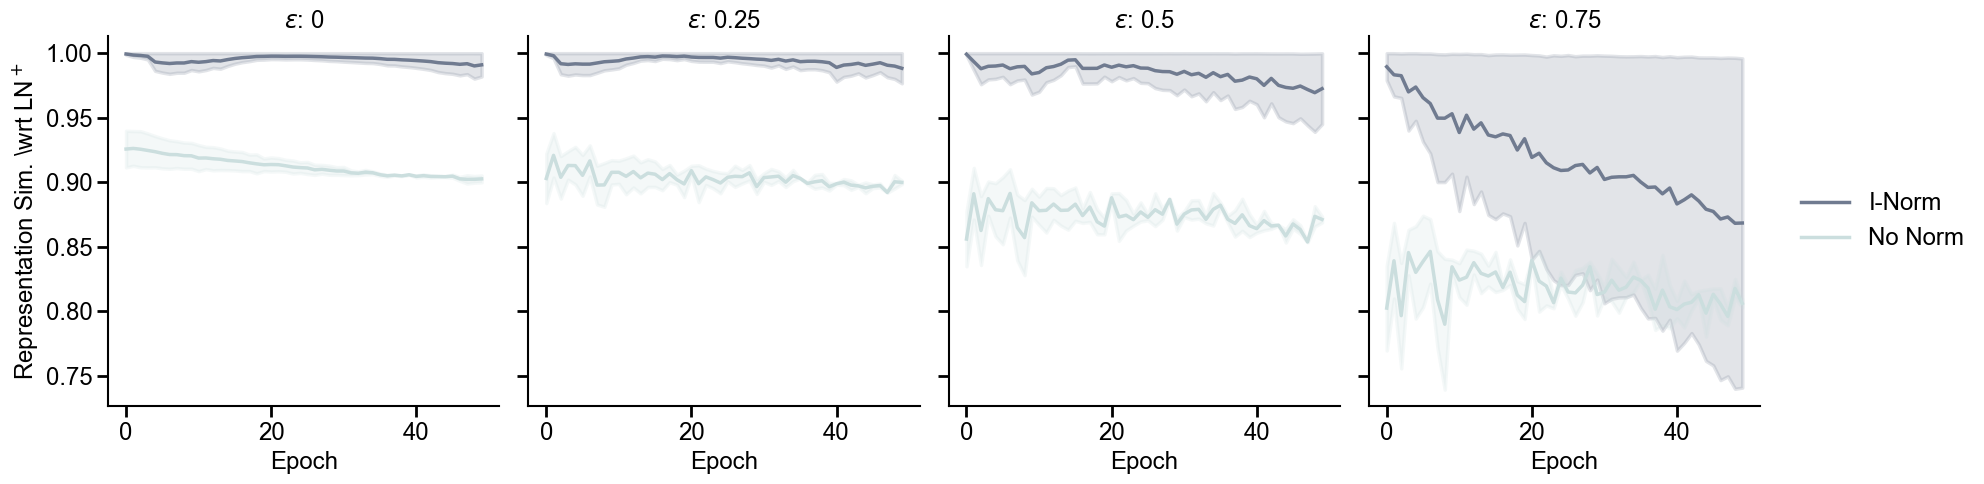

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm, colors

# Truncate bone colormap to avoid white
def truncate_colormap(cmap, minval=0.0, maxval=0.85, n=100):
    return colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Setup
brightness_factors = [0, 0.25, 0.5, 0.75]
ln_feedback_types = ['Homeostasis', 'No Homeostasis']
layers_to_average = ["fc0", "fc1"]

# Colors
trunc_bone = truncate_colormap(cm.get_cmap('bone'), 0.5, 0.85)
colors_bone = [trunc_bone(i / (len(ln_feedback_types) - 1)) for i in range(len(ln_feedback_types))]

# Create 1x4 subplot grid (one row, four columns)
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
axs = axs.flatten()

# Loop over brightness factors (each gets its own subplot)
for b_idx, bright in enumerate(brightness_factors):
    ax = axs[b_idx]

    for f_idx, ln_fdb in enumerate(ln_feedback_types):
        all_layer_data = []

        for layer in layers_to_average:
            # Fetch runs for this brightness and feedback type
            runs = fetch_runs(
                api,
                entity='project_danns',
                project_name='Luminosity_LNHomeostasis',
                filters={
                    "config.dataset": "fashionmnist",
                    "config.brightness_factor": bright,
                    "config.homeostasis": 1 if ln_fdb == 'Homeostasis' else 0,
                    "config.normtype": 0,
                    "config.normtype_detach": 1,
                    "config.excitation_training": 1 if ln_fdb == 'Homeostasis' else 0,
                    "config.layer_norm": None if ln_fdb == 'Homeostasis' else 0,
                    "config.use_testset": True,
                    "config.ln_feedback": 'center' if ln_fdb == 'Homeostasis' else None,
                },
                order="-summary_metrics.test_acc"
            )

            layer_histories = []

            for run in runs:
                hist = run.history(samples=5000000, keys=[f"output_alignment_{layer}"])
                if f"output_alignment_{layer}" in hist:
                    values = hist[f"output_alignment_{layer}"].astype(float).values
                    if not np.any(np.isnan(values)):
                        layer_histories.append(values)

            if layer_histories:
                # Truncate all histories to the shortest one
                min_len = min(len(arr) for arr in layer_histories)
                print(f'{ln_fdb} - {bright} - {layer} - {min_len}')
                truncated = [arr[:min_len] for arr in layer_histories]
                stacked = np.stack(truncated)
                all_layer_data.append(stacked)

        # Average across fc0 and fc1
        if all_layer_data:
            all_layer_data = np.stack(all_layer_data)  # shape: [2, num_runs, T]
            mean_per_layer = np.mean(all_layer_data, axis=1)  # shape: [2, T]
            avg_across_layers = np.mean(mean_per_layer, axis=0)
            std_across_layers = np.std(mean_per_layer, axis=0)

            ax.plot(
                avg_across_layers,
                label='I-Norm' if ln_fdb == 'Homeostasis' else 'No Norm',
                color=colors_bone[f_idx]
            )
            ax.fill_between(
                range(len(avg_across_layers)),
                avg_across_layers - std_across_layers,
                avg_across_layers + std_across_layers,
                alpha=0.2,
                color=colors_bone[f_idx]
            )

    ax.set_title(f"$\epsilon$: {bright}")
    ax.set_xlabel("Epoch")
    if b_idx == 0:
        ax.set_ylabel("Representation Sim. \wrt LN$^+$")
    ax.yaxis.set_major_formatter(ScalarFormatter())

# Legend outside the last subplot (on the right)
axs[-1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)

plt.tight_layout()
plt.savefig("figure2d.svg", format="svg")


/tmp/ipykernel_980805/212464069.py:87: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  var_ax.set_ylim([1 - var_deviation * 1.2, 1 + var_deviation * 1.2])


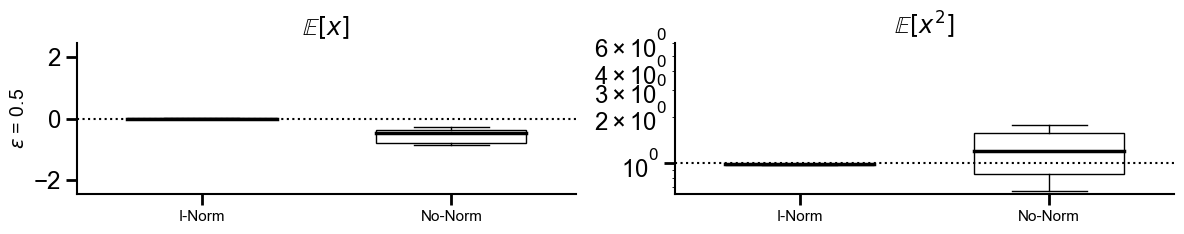

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mu_var_for_epsilon(epsilon):
    ln_feedback_types = ['I-Norm', 'No-Norm']
    mean_color = "black"
    var_color = "black"

    fig, axs = plt.subplots(1, 2, figsize=(12, 2.5), sharey=False)
    fig.subplots_adjust(wspace=0.3)

    # Collect data
    mu_data = []
    var_data = []
    for ln_fdb in ln_feedback_types:
        runs = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": epsilon,
                "config.homeostasis": 1 if ln_fdb == 'I-Norm' else 0,
                "config.normtype": 0,
                "config.normtype_detach": 1,
                "config.excitation_training": 1 if ln_fdb == 'I-Norm' else 0,
                "config.layer_norm": None if ln_fdb == 'I-Norm' else 0,
                "config.use_testset": True,
                "config.lambda_homeo": 0.01 if ln_fdb == 'I-Norm' else 1,
            },
            order="-summary_metrics.test_acc"
        )[:10]

        mu_vals, var_vals = [], []
        for run in runs:
            try:
                mu0 = float(run.summary.get("train_fc0_mu", np.nan))
                mu1 = float(run.summary.get("train_fc1_mu", np.nan))
                var0 = float(run.summary.get("train_fc0_var", np.nan))
                var1 = float(run.summary.get("train_fc1_var", np.nan))
            except (TypeError, ValueError):
                continue

            if np.isnan(mu0) or np.isnan(mu1) or np.isnan(var0) or np.isnan(var1):
                continue

            mu_vals.append((mu0 + mu1) / 2)
            var_vals.append((var0 + var1) / 2)

        mu_data.append(mu_vals)
        var_data.append(var_vals)

    # ----- Plot first moment (μ) -----
    mu_ax = axs[0]
    mu_ax.boxplot(
        mu_data, positions=np.arange(1, len(ln_feedback_types) + 1), widths=0.6,
        patch_artist=True,
        boxprops=dict(color='black', facecolor='none'),
        medianprops=dict(linewidth=2.5, color=mean_color),
        showfliers=False
    )
    mu_ax.axhline(y=0, color=mean_color, linestyle="dotted", linewidth=1.5)
    mu_ax.set_ylabel(f"$\epsilon$ = {epsilon}", fontsize=14)   # <-- y-axis is epsilon
    mu_ax.set_xticks(np.arange(1, len(ln_feedback_types) + 1))
    mu_ax.set_xticklabels(ln_feedback_types, fontsize=11)
    mu_data_all = np.concatenate(mu_data)
    mu_max_abs = np.nanmax(np.abs(mu_data_all))
    mu_ax.set_ylim([-mu_max_abs * 1.1, mu_max_abs * 1.1])
    mu_ax.set_title(r"$\mathbb{E}[x]$")

    # ----- Plot second moment (σ²) -----
    var_ax = axs[1]
    var_ax.boxplot(
        var_data, positions=np.arange(1, len(ln_feedback_types) + 1), widths=0.6,
        patch_artist=True,
        boxprops=dict(color='black', facecolor='none'),
        medianprops=dict(linewidth=2.5, color=var_color),
        showfliers=False
    )
    var_ax.axhline(y=1, color=var_color, linestyle="dotted", linewidth=1.5)
    # var_ax.set_ylabel(f"$\epsilon$ = {epsilon}", fontsize=14)   # <-- y-axis is epsilon
    var_ax.set_xticks(np.arange(1, len(ln_feedback_types) + 1))
    var_ax.set_xticklabels(ln_feedback_types, fontsize=11)
    var_ax.set_yscale("log")
    var_data_all = np.concatenate(var_data)
    var_deviation = np.nanmax(np.abs(var_data_all - 1))
    var_ax.set_ylim([1 - var_deviation * 1.2, 1 + var_deviation * 1.2])
    var_ax.set_title(r"$\mathbb{E}[x^2]$")

    plt.tight_layout()
    plt.savefig(f"figure2b(eps={epsilon}).svg", format="svg")
    plt.show()


# Example usage:
plot_mu_var_for_epsilon(0.5)


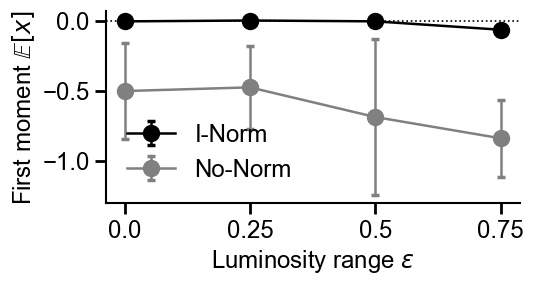

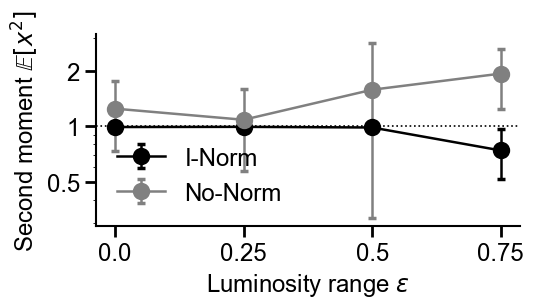

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mu_var_across_epsilons(epsilons):
    ln_feedback_types = ['I-Norm', 'No-Norm']
    colors = {'I-Norm': 'black', 'No-Norm': 'gray'}

    # Data containers
    mu_means = {t: [] for t in ln_feedback_types}
    mu_stds = {t: [] for t in ln_feedback_types}
    var_means = {t: [] for t in ln_feedback_types}
    var_stds = {t: [] for t in ln_feedback_types}

    # Collect across epsilons
    for epsilon in epsilons:
        for ln_fdb in ln_feedback_types:
            runs = fetch_runs(
                api,
                entity='project_danns',
                project_name='Luminosity_LNHomeostasis',
                filters={
                    "config.dataset": "fashionmnist",
                    "config.brightness_factor": epsilon,
                    "config.homeostasis": 1 if ln_fdb == 'I-Norm' else 0,
                    "config.normtype": 0,
                    "config.normtype_detach": 1,
                    "config.excitation_training": 1 if ln_fdb == 'I-Norm' else 0,
                    "config.layer_norm": None if ln_fdb == 'I-Norm' else 0,
                    "config.use_testset": True,
                    "config.lambda_homeo": 0.01 if ln_fdb == 'I-Norm' else 1,
                },
                order="-summary_metrics.test_acc"
            )[:10]

            mu_vals, var_vals = [], []
            for run in runs:
                try:
                    mu0 = float(run.summary.get("train_fc0_mu", np.nan))
                    mu1 = float(run.summary.get("train_fc1_mu", np.nan))
                    var0 = float(run.summary.get("train_fc0_var", np.nan))
                    var1 = float(run.summary.get("train_fc1_var", np.nan))
                except (TypeError, ValueError):
                    continue

                if np.isnan(mu0) or np.isnan(mu1) or np.isnan(var0) or np.isnan(var1):
                    continue

                mu_vals.append((mu0 + mu1) / 2)
                var_vals.append((var0 + var1) / 2)

            # Compute mean ± std for each epsilon
            mu_means[ln_fdb].append(np.nanmean(mu_vals))
            mu_stds[ln_fdb].append(np.nanstd(mu_vals))
            var_means[ln_fdb].append(np.nanmean(var_vals))
            var_stds[ln_fdb].append(np.nanstd(var_vals))

    # Convert epsilons to categorical x-ticks
    x = np.arange(len(epsilons))

    # ---- Plot first moment (μ) ----
    fig, ax1 = plt.subplots(figsize=(5.5, 3))
    for ln_fdb in ln_feedback_types:
        ax1.errorbar(
            x,
            mu_means[ln_fdb],
            yerr=mu_stds[ln_fdb],
            label=ln_fdb,
            color=colors[ln_fdb],
            marker='o',
            capsize=3,
            linewidth=1.8,
        )
    ax1.axhline(0, color='black', linestyle='dotted', linewidth=1.2)
    ax1.set_xticks(x)
    ax1.set_xticklabels([str(e) for e in epsilons])
    ax1.set_xlabel(r"Luminosity range $\epsilon$")
    ax1.set_ylabel(r"First moment $\mathbb{E}[x]$")
    ax1.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("figure2b_first_moment.svg", format="svg")
    plt.show()

    # ---- Plot second moment (σ²) ----
    fig, ax2 = plt.subplots(figsize=(5.5, 3))
    for ln_fdb in ln_feedback_types:
        ax2.errorbar(
            x,
            var_means[ln_fdb],
            yerr=var_stds[ln_fdb],
            label=ln_fdb,
            color=colors[ln_fdb],
            marker='o',
            capsize=3,
            linewidth=1.8,
        )
    ax2.axhline(1, color='black', linestyle='dotted', linewidth=1.2)
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(e) for e in epsilons])
    ax2.set_xlabel(r"Luminosity range $\epsilon$")
    ax2.set_ylabel(r"Second moment $\mathbb{E}[x^2]$")
    ax2.set_yscale("log")

     # ---- Add denser y-ticks ----
    # Auto-select y-ticks based on range or use a standard range
    all_var_vals = np.concatenate([var_means[t] for t in ln_feedback_types])
    vmin, vmax = np.nanmin(all_var_vals), np.nanmax(all_var_vals)
    yticks = np.array([0.1, 0.2, 0.5, 1, 2, 5, 10])
    yticks = yticks[(yticks >= vmin / 2) & (yticks <= vmax * 2)]
    if len(yticks) > 0:
        ax2.set_yticks(yticks)
        ax2.get_yaxis().set_major_formatter(plt.ScalarFormatter())
        ax2.set_yticklabels([f"{y:g}" for y in yticks])

    ax2.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("figure2b_second_moment.svg", format="svg")
    plt.show()


# Example usage:
epsilons = [0.0, 0.25, 0.5, 0.75]
plot_mu_var_across_epsilons(epsilons)


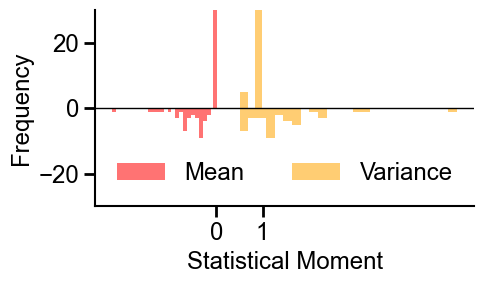

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mu_var_across_epsilons(epsilons):
    ln_feedback_types = ['I-Norm', 'No-Norm']

    # Containers: list of lists (one list per ε), to be flattened later
    mu_vals_by_eps = {t: [] for t in ln_feedback_types}
    var_vals_by_eps = {t: [] for t in ln_feedback_types}

    # -----------------------------
    # Collect values across epsilons
    # -----------------------------
    for epsilon in epsilons:
        for ln_fdb in ln_feedback_types:
            runs = fetch_runs(
                api,
                entity='project_danns',
                project_name='Luminosity_LNHomeostasis',
                filters={
                    "config.dataset": "fashionmnist",
                    "config.brightness_factor": epsilon,
                    "config.homeostasis": 1 if ln_fdb == 'I-Norm' else 0,
                    "config.normtype": 0,
                    "config.normtype_detach": 1,
                    "config.excitation_training": 1 if ln_fdb == 'I-Norm' else 0,
                    "config.layer_norm": None if ln_fdb == 'I-Norm' else 0,
                    "config.use_testset": True,
                    "config.lambda_homeo": 0.01 if ln_fdb == 'I-Norm' else 1,
                },
                order="-summary_metrics.test_acc"
            )[:10]

            mu_vals = []
            var_vals = []

            for run in runs:
                try:
                    mu0 = float(run.summary.get("train_fc0_mu", np.nan))
                    mu1 = float(run.summary.get("train_fc1_mu", np.nan))
                    var0 = float(run.summary.get("train_fc0_var", np.nan))
                    var1 = float(run.summary.get("train_fc1_var", np.nan))
                except (TypeError, ValueError):
                    continue

                if np.isnan(mu0) or np.isnan(mu1) or np.isnan(var0) or np.isnan(var1):
                    continue

                mu_vals.append((mu0 + mu1) / 2)
                var_vals.append((var0 + var1) / 2)

            mu_vals_by_eps[ln_fdb].append(mu_vals)
            var_vals_by_eps[ln_fdb].append(var_vals)

    # -----------------------------
    # Flatten all epsilons together
    # -----------------------------
    mu_I = np.concatenate(mu_vals_by_eps["I-Norm"])
    var_I = np.concatenate(var_vals_by_eps["I-Norm"])
    mu_N = np.concatenate(mu_vals_by_eps["No-Norm"])
    var_N = np.concatenate(var_vals_by_eps["No-Norm"])

    # -----------------------------
    # Bihistogram plotting
    # -----------------------------
    def mirrored_hist(ax, data, bins, color, label):
        counts, edges = np.histogram(data, bins=bins)
        mids = (edges[:-1] + edges[1:]) / 2
        ax.bar(
            mids, -counts,
            width=(edges[1] - edges[0]),
            color=color,
            alpha=0.55,
            label=label,
        )

    # fig, ax1 = plt.subplots(figsize=(5.5, 3))
    fig, ax = plt.subplots(figsize=(5, 3))
    colors = {"mean": "red", "var": "orange"}

    # --------------------
    # TOP = I-Norm
    # --------------------
    ax.hist(
        mu_I, bins=1, color=colors["mean"], alpha=0.55
    )
    ax.hist(
        var_I, bins=3, color=colors["var"], alpha=0.55
    )

    # --------------------
    # BOTTOM = No-Norm
    # --------------------
    mirrored_hist(ax, mu_N, 25, colors["mean"], "Mean")
    mirrored_hist(ax, var_N, 25, colors["var"], "Variance")

    # --------------------
    # Formatting
    # --------------------
    ax.axhline(0, color='black', linewidth=1)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Statistical Moment")
    ax.set_ylim(-30, 30)
    ax.set_xticks([0, 1])

    ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.savefig("figure2b_c.svg", format="svg")
    plt.show()


# -----------------------------
# Example usage
# -----------------------------
epsilons = [0.0, 0.25, 0.5, 0.75]
plot_mu_var_across_epsilons(epsilons)

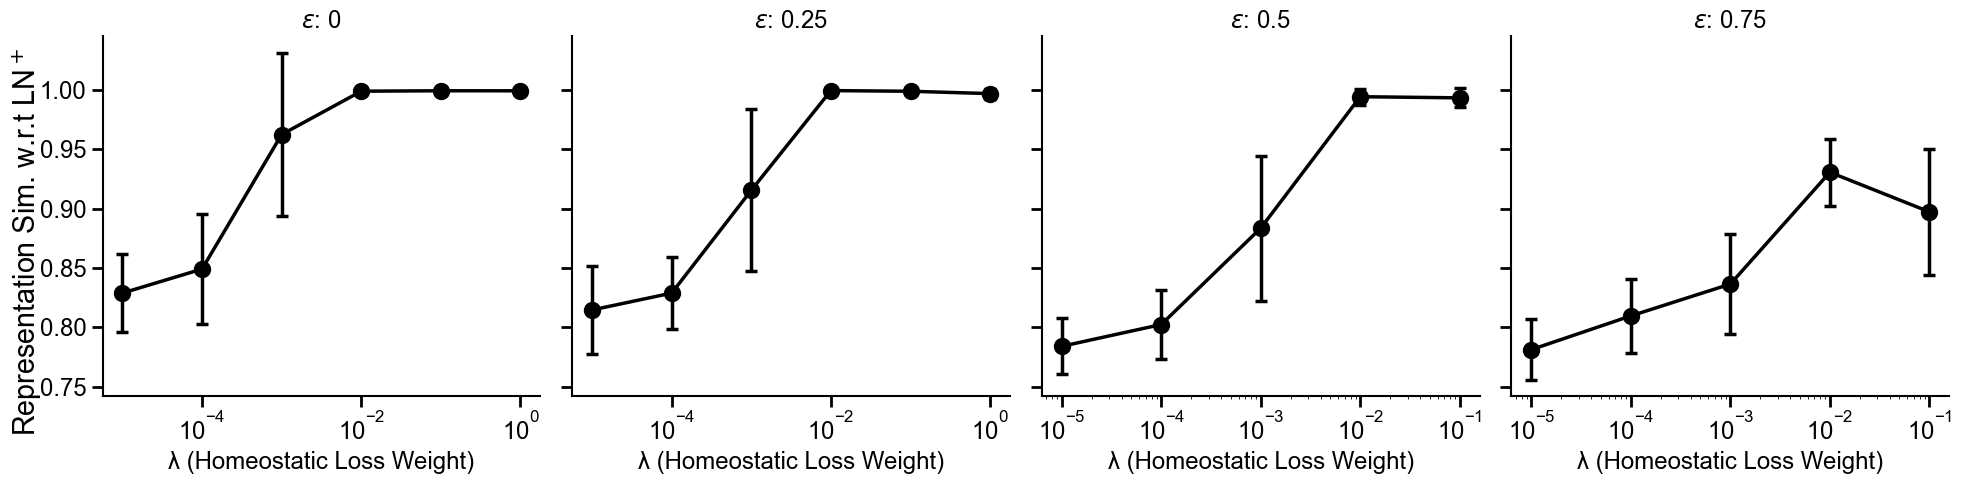

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm, colors

# Truncate bone colormap to avoid white
def truncate_colormap(cmap, minval=0.0, maxval=0.85, n=100):
    return colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Setup
brightness_factors = [0, 0.25, 0.5, 0.75]
layers_to_average = ["fc0", "fc1"]
lambdas_homeos = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

# Colors
trunc_bone = truncate_colormap(cm.get_cmap('bone'), 0.5, 0.85)
color_inorm = trunc_bone(0.5)

# Create 1x4 subplot grid (one row, four columns)
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
axs = axs.flatten()

# Loop over brightness factors (each gets its own subplot)
for b_idx, bright in enumerate(brightness_factors):
    ax = axs[b_idx]

    mean_final_vals = []
    std_final_vals = []

    for lambda_val in lambdas_homeos:
        per_run_means = []

        runs = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": bright,
                "config.homeostasis": 1,
                "config.normtype": 0,
                "config.normtype_detach": 1,
                "config.excitation_training": 1,
                "config.ln_feedback": 'full',
                "config.lambda_homeo": lambda_val,
            },
            order="-summary_metrics.test_acc"
        )

        

        for run in runs[:5]:
            vals = []
            for layer in layers_to_average:
                key = f"output_alignment_{layer}"
                if key in run.summary:
                    vals.append(float(run.summary[key]))
            if vals:
                per_run_means.append(np.mean(vals))

        if per_run_means:
            mean_final_vals.append(np.mean(per_run_means))
            std_final_vals.append(np.std(per_run_means))
        else:
            
            mean_final_vals.append(np.nan)
            std_final_vals.append(np.nan)

    mean_final_vals = np.array(mean_final_vals)
    std_final_vals = np.array(std_final_vals)


    ax.errorbar(
        lambdas_homeos,
        mean_final_vals,
        yerr=std_final_vals,
        color="black",
        marker='o',
        capsize=4,
        label='I-Norm'
    )

    ax.set_title(f"$\\epsilon$: {bright}")
    ax.set_xlabel("λ (Homeostatic Loss Weight)")
    ax.set_xscale("log")
    # if b_idx == 0:
    #     ax.set_ylabel("Final Representation Sim. w.r.t LN$^+$")
    # ax.yaxis.set_major_formatter(ScalarFormatter())

# axs[-1].legend(
#     loc='center left',
#     bbox_to_anchor=(1.05, 0.5),
#     frameon=False
# )

fig.supylabel("Representation Sim. w.r.t LN$^+$")
# fig.supxlabel("λ (I-Norm Loss Weight)")

plt.tight_layout()
plt.savefig("figure2c", format="svg")


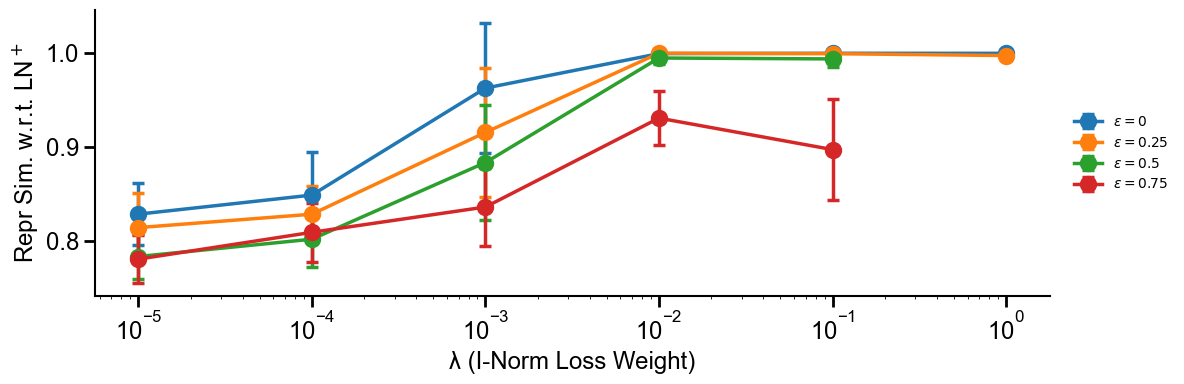

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Setup
brightness_factors = [0, 0.25, 0.5, 0.75]
layers_to_average = ["fc0", "fc1"]
lambdas_homeos = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

# Use discrete colors
colors_eps = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(12, 4))

for bright, color in zip(brightness_factors, colors_eps):
    mean_final_vals = []
    std_final_vals = []

    for lambda_val in lambdas_homeos:
        per_run_means = []

        runs = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": bright,
                "config.homeostasis": 1,
                "config.normtype": 0,
                "config.normtype_detach": 1,
                "config.excitation_training": 1,
                "config.ln_feedback": 'full',
                "config.lambda_homeo": lambda_val,
            },
            order="-summary_metrics.test_acc"
        )

        for run in runs[:5]:
            vals = []
            for layer in layers_to_average:
                key = f"output_alignment_{layer}"
                if key in run.summary:
                    vals.append(float(run.summary[key]))
            if vals:
                per_run_means.append(np.mean(vals))

        if per_run_means:
            mean_final_vals.append(np.mean(per_run_means))
            std_final_vals.append(np.std(per_run_means))
        else:
            mean_final_vals.append(np.nan)
            std_final_vals.append(np.nan)

    mean_final_vals = np.array(mean_final_vals)
    std_final_vals = np.array(std_final_vals)

    plt.errorbar(
        lambdas_homeos,
        mean_final_vals,
        yerr=std_final_vals,
        color=color,
        marker='o',
        capsize=4,
        label=f"$\\epsilon={bright}$"
    )

plt.xscale("log")
plt.xlabel("λ (I-Norm Loss Weight)")
plt.ylabel("Repr Sim. w.r.t. LN$^+$")
# plt.title("I-Norm: Effect of Brightness Factor and λ")

# Place legend to the right of the plot
plt.legend(frameon=False, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0, fontsize=10)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on right for legend
plt.savefig("figure2c.svg", format="svg")
plt.show()
